## Cleanup Previo
En el respositorio del proyecto se encuentran dos pequeños scripts de Python, `download.py` y `rewrite.py`. Estos scripts fueron ejecutados para descargar el set de datos de la página provista, y juntar los resultados (varios archivos `.csv`) en un sólo archivo, a través de `pandas`. A partir de este último, se hace un filtrado de los resultados por ubicación de las propiedades, para quedarnos solo con las del Gran Buenos Aires. Este último DataFrame es el punto de partida de nuestro análisis exploratorio, y para no tener que correr la limpieza cada vez que se trabaja sobre él, se guarda en un csv nuevo.

In [71]:
import pandas as pd
import numpy as np
import mplleaflet
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
%matplotlib inline  

## Carga de datos
Cargo solo las columnas que nos pueden llegar a interesar. En particular, ignoro varias que tienen URL a imágenes y descripciones de las propiedades individuales. 

In [72]:
dtypes = {
    'country_name': str,
    'expenses': object,
    'id': str,
    'title': str,
    'state_name': str,
    'lat': float,
    'lon': float
}
cols = range(6) + range(8, 18) + [20, 21] + range(23, 27)
df = pd.read_csv('data/data_gba_total.csv', dtype=dtypes, usecols=cols)


In [73]:
len(df)

2409471

In [74]:
df.head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
0,Argentina,2015-07-01,USD,1500.0,NaN,3430234.0,-34.574594,"-34.5745944268,-58.4192548517",-58.419255,sell,...,71000.0,1133763.5,71000.0,2448.275862,apartment,1.0,29.0,NaN,29.0,Departamento en Palermo
1,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,96000.0,1532976.0,96000.0,2285.714286,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 6º- A ESTRENAR
2,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,86000.0,1373291.0,86000.0,2047.619048,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 4º- A ESTRENAR
3,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.639086,"-34.639086,-58.369347",-58.369347,sell,...,165000.0,2634802.5,165000.0,2115.384615,apartment,1.0,78.0,NaN,86.0,DEPARTAMENTO EN VENTA
4,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.678121,"-34.6781214564,-58.3922113975",-58.392211,sell,...,85000.0,1357322.5,85000.0,1133.333333,house,NaN,75.0,NaN,65.0,Duplex en PH - Avellaneda - Excelente


In [75]:
df.columns

Index([u'country_name', u'created_on', u'currency', u'expenses', u'floor',
       u'geonames_id', u'lat', u'lat-lon', u'lon', u'operation', u'place_name',
       u'place_with_parent_names', u'price', u'price_aprox_local_currency',
       u'price_aprox_usd', u'price_per_m2', u'property_type', u'rooms',
       u'surface_covered_in_m2', u'surface_in_m2', u'surface_total_in_m2',
       u'title'],
      dtype='object')

Verifico que los precios sean lógicos (por lo menos positivos!)

In [76]:
df.sort_values('price_aprox_usd').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
86890,Argentina,2016-08-30,NaN,NaN,NaN,6693229.0,-34.594147,"-34.5941468,-58.4424053",-58.442405,sell,...,0.0,0.0,0.0,NaN,apartment,NaN,38.0,NaN,38.0,Departamento de 1 ambiente en Venta en
696892,Argentina,2016-04-26,USD,NaN,NaN,NaN,NaN,NaN,NaN,sell,...,0.0,0.0,0.0,NaN,house,4.0,102.0,NaN,132.0,Triplex en Venta Haedo / Moron (A124 458)
583482,Argentina,2016-11-18,NaN,NaN,NaN,3832749.0,-34.933653,"-34.933653,-57.889302",-57.889302,sell,...,0.0,0.0,0.0,NaN,house,3.0,NaN,NaN,NaN,Casa de 2 dormitorios con parque en Villa Elvira
16739,Argentina,2015-12-29,NaN,NaN,NaN,3435874.0,NaN,NaN,NaN,sell,...,0.0,0.0,0.0,NaN,apartment,NaN,NaN,NaN,NaN,U$D 98.000 - Departamento en Venta - Alberdi ...
696864,Argentina,2016-06-14,USD,NaN,NaN,3429617.0,NaN,NaN,NaN,sell,...,0.0,0.0,0.0,NaN,apartment,3.0,84.0,NaN,NaN,Semipiso en Venta Ramos Mejia / La Matanza (A0...


In [77]:
df = df[df['price_aprox_usd'] > 0]

In [78]:
df.sort_values('price_aprox_usd').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
549065,Argentina,2015-07-19,ARS,NaN,NaN,3436394.0,-34.828152,"-34.8281517,-58.3865471",-58.386547,sell,...,45701.0,48432.14,3032.98,3515.461538,apartment,1.0,13.0,NaN,14.0,Departamentos venta
3488,Argentina,2015-08-27,ARS,NaN,NaN,3436003.0,-34.625948,"-34.6259482,-58.4195408",-58.419541,sell,...,46405.0,49178.18,3079.70,1546.833333,apartment,1.0,30.0,NaN,30.0,Departamentos venta
10644,Argentina,2015-08-27,ARS,NaN,NaN,3436003.0,-34.625948,"-34.6259482,-58.4195408",-58.419541,sell,...,46405.0,49178.18,3079.70,1546.833333,apartment,1.0,30.0,NaN,30.0,Departamentos venta
17796,Argentina,2015-09-01,ARS,NaN,NaN,3436003.0,-34.624386,"-34.6243863,-58.4071151",-58.407115,sell,...,52684.0,55832.42,3496.41,1756.133333,apartment,1.0,30.0,NaN,30.0,Departamentos venta
3492,Argentina,2015-09-01,ARS,NaN,NaN,3436003.0,-34.624386,"-34.6243863,-58.4071151",-58.407115,sell,...,52684.0,55832.42,3496.41,1756.133333,apartment,1.0,30.0,NaN,30.0,Departamentos venta


In [79]:
len(df) # Cantidad de propiedades (para ver cuantas filtramos)

2085725

Siguen habiendo varias propiedades inválidas (200 pesos?).

In [80]:
df = df[df['price_aprox_usd'] > 20000]
df.sort_values('price').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
34129,Argentina,2016-04-07,ARS,2600.0,NaN,3436077.0,-34.560519,"-34.5605187244,-58.4581508838",-58.458151,sell,...,2600.0,6227715.00,390000.0,NaN,store,NaN,NaN,NaN,NaN,LOCAL EN VENTA
27053,Argentina,2016-04-07,ARS,2600.0,NaN,3436077.0,-34.560519,"-34.5605187244,-58.4581508838",-58.458151,sell,...,2600.0,6227715.00,390000.0,NaN,store,NaN,NaN,NaN,NaN,LOCAL EN VENTA
2272929,NaN,2014-10-23,USD,NaN,2.0,3430550.0,NaN,NaN,NaN,sell,...,20400.0,177881.88,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,DEPARTAMENTO EN VENTA
2239717,NaN,2014-10-23,USD,NaN,2.0,3430550.0,-34.627344,"-34.627344,-58.74595",-58.745950,sell,...,20400.0,173461.20,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,NaN
2264226,NaN,2014-10-23,USD,NaN,2.0,3430550.0,NaN,NaN,NaN,sell,...,20400.0,176137.68,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,NaN


Veo una propiedad repetida varias veces. A ver el csv original? 

In [81]:
oct_2014 = pd.read_csv("data/properati-AR-2014-11-01-properties-sell.csv")
oct_2014

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
0,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,NaN,NaN,NaN,110000.0,USD,935330.00,110000.00,220.0,500.000000,NaN,4.0,NaN,http://www.properati.com.ar/ak_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/GP0G5PgOx...
1,2012-08-08,sell,apartment,General San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3433778.0,"-34.488179,-58.56148",-34.488179,-58.561480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,http://www.properati.com.ar/ao_venta_departame...,http://d1t4y5hzjn9jnl.cloudfront.net/pTD8O5N_X...
2,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.553995,-58.556645",-34.553995,-58.556645,NaN,NaN,NaN,NaN,273.0,NaN,NaN,4.0,NaN,http://www.properati.com.ar/aw_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/fl10ghG3d...
3,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.553385,-58.551283",-34.553385,-58.551283,NaN,NaN,NaN,NaN,480.0,NaN,NaN,5.0,NaN,http://www.properati.com.ar/be_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/f-1cqxLl8...
4,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.542755,-58.566699",-34.542755,-58.566699,NaN,NaN,NaN,NaN,504.0,NaN,NaN,5.0,NaN,http://www.properati.com.ar/bg_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/7LA434b0I...
5,2012-08-29,sell,apartment,Constitución,|Argentina|Capital Federal|Constitución|,3435257.0,"-34.628097,-58.390967",-34.628097,-58.390967,69000.0,USD,586707.00,69000.00,36.0,1916.666667,NaN,1.0,NaN,http://www.properati.com.ar/dny_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/1L7lsPTmu...
6,2012-08-29,sell,apartment,Constitución,|Argentina|Capital Federal|Constitución|,3435257.0,"-34.628097,-58.390967",-34.628097,-58.390967,61200.0,USD,520383.60,61200.00,36.0,1700.000000,NaN,1.0,NaN,http://www.properati.com.ar/do0_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/3d6y5krBT...
7,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,3429244.0,"-34.676801,-58.693682",-34.676801,-58.693682,120000.0,USD,1020360.00,120000.00,333.0,360.360360,NaN,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,http://d1t4y5hzjn9jnl.cloudfront.net/eG4H2yo7Q...
8,2012-09-28,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,3430234.0,"-34.574575,-58.421667",-34.574575,-58.421667,160000.0,USD,1360480.00,160000.00,50.0,3200.000000,NaN,2.0,NaN,http://www.properati.com.ar/wjj_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/NpVXGyi_p...
9,2012-10-03,sell,apartment,Retiro,|Argentina|Capital Federal|Retiro|,3429576.0,"-34.594682,-58.377005",-34.594682,-58.377005,NaN,NaN,NaN,NaN,290.0,NaN,3.0,5.0,NaN,http://www.properati.com.ar/zq9_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/jLG35H0Fw...


In [82]:
oct_2014[oct_2014['lat'] == -34.627344]

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
23365,2014-04-29,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,66210.0,USD,562983.63,66210.0,171.0,387.192982,NaN,4.0,NaN,http://www.properati.com.ar/f6n1_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/CFnJOoEQY...
23366,2014-04-29,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,66450.0,USD,565024.35,66450.0,182.0,365.109890,NaN,4.0,NaN,http://www.properati.com.ar/f6n2_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/-VnsAN6-E...
53018,2014-09-19,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|Mor...,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,130000.0,USD,1105390.00,130000.0,300.0,433.333333,NaN,NaN,NaN,http://www.properati.com.ar/inu4_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/UlhmaXZX4...
61630,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,20400.0,USD,173461.20,20400.0,87.0,234.482759,2.0,3.0,NaN,http://www.properati.com.ar/j54d_venta_departa...,NaN
61640,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,24820.0,USD,211044.46,24820.0,93.0,266.881720,NaN,3.0,NaN,http://www.properati.com.ar/j54q_venta_departa...,NaN
61644,2014-10-23,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,NaN,NaN,NaN,NaN,800.0,NaN,NaN,3.0,NaN,http://www.properati.com.ar/j54u_venta_casa_mo...,NaN
61645,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,19960.0,USD,169719.88,19960.0,60.0,332.666667,NaN,2.0,NaN,http://www.properati.com.ar/j54v_venta_departa...,NaN


Claramente los datos vienen repetidos y no fue un error en el rejunte de todos los archivos en uno sólo. Las borro:

In [83]:
df = df.drop_duplicates(subset=['lat', 'lon', 'price_aprox_usd'])

In [84]:
len(df) # Cantidad de propiedades (para ver cuantas filtramos)

430440

In [85]:
df.sort_values('price_aprox_usd').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
1384398,NaN,2015-09-01,ARS,NaN,3.0,3427528.0,-34.638365,"-34.638365,-58.503681",-58.503681,sell,...,190319.0,190318.99,20011.25,NaN,apartment,1.0,NaN,NaN,NaN,A ESTRENAR- Anticipo y CUOTAS de PESOS 7.930.-
2024746,NaN,2014-03-25,ARS,NaN,NaN,NaN,NaN,NaN,NaN,sell,...,170000.0,170248.25,20022.14,NaN,house,NaN,NaN,300.0,NaN,NaN
1788822,NaN,2015-04-30,ARS,NaN,NaN,3434130.0,-34.399863,"-34.399863,-58.737245",-58.737245,sell,...,182000.0,182210.31,20034.34,NaN,apartment,1.0,NaN,NaN,NaN,VENTA DEPTOS Y ESTUDIOS CON FINANCIACION EN PESOS
943545,NaN,2013-12-02,ARS,NaN,NaN,3435356.0,-34.572905,"-34.572905,-58.451799",-58.451799,sell,...,138000.0,137999.94,20045.02,NaN,apartment,2.0,NaN,46.0,NaN,NaN
981898,NaN,2014-02-13,ARS,NaN,NaN,3430234.0,-34.577374,"-34.577374,-58.422593",-58.422593,sell,...,138000.0,157217.10,20045.02,NaN,apartment,2.0,NaN,55.0,NaN,NaN


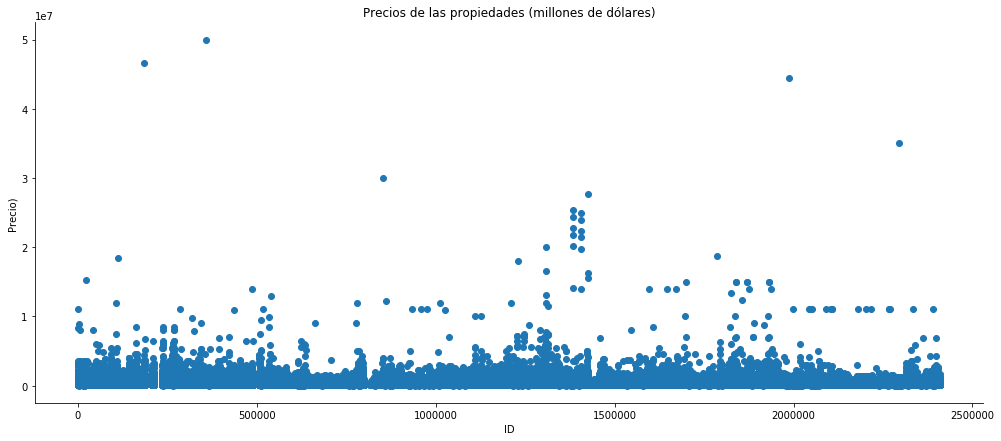

In [86]:
x = df.index
y = df['price_aprox_usd']


fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Precios de las propiedades (millones de dólares)')
ax.set_ylabel('Precio)')
ax.set_xlabel('ID')
ax.scatter(x,y)

La gran mayoría de precios se encuentran debajo del millón de dólares. Veamos la distribución del precio:

In [87]:
df['price_aprox_usd'].describe()

count    4.304400e+05
mean     2.068996e+05
std      3.597598e+05
min      2.001125e+04
25%      8.865248e+04
50%      1.315810e+05
75%      2.200000e+05
max      5.000000e+07
Name: price_aprox_usd, dtype: float64

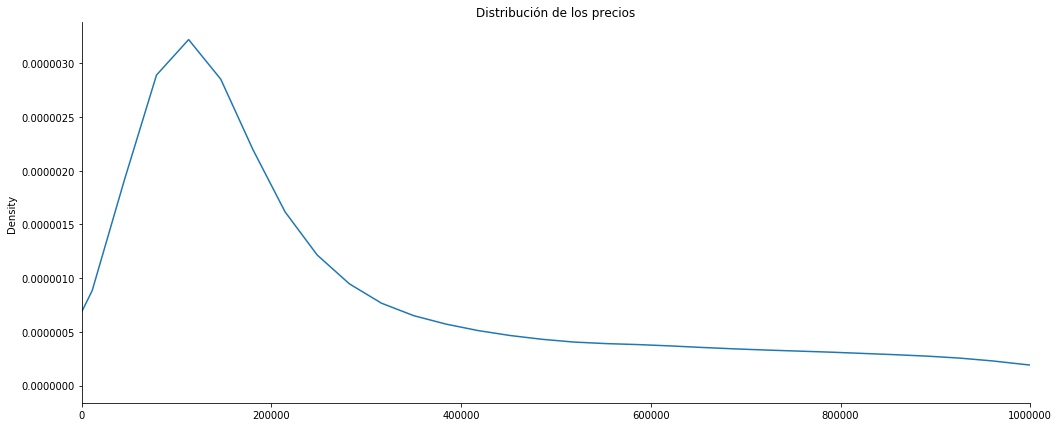

In [88]:
price = df[df['price_aprox_usd'] < 1000000].price

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Distribución de los precios')
ax.axis(xmin=0, xmax=1000000)
price.plot.kde(ax=ax)

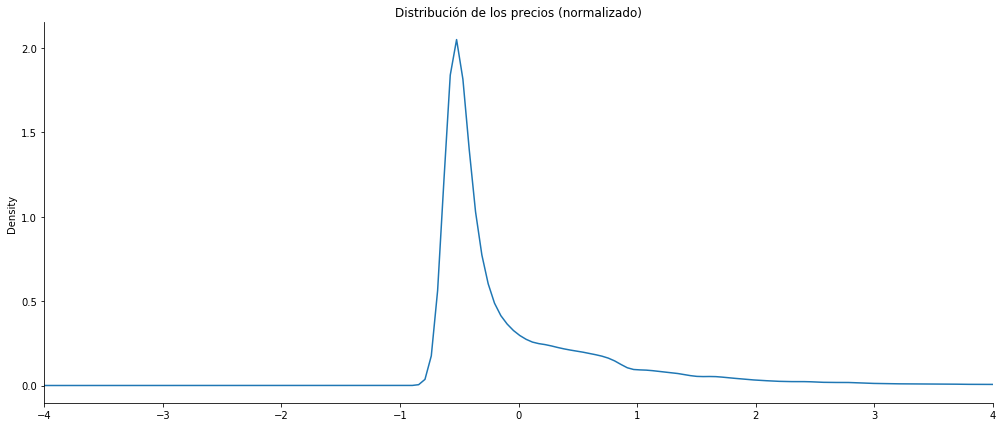

In [89]:
price = df[df['price_aprox_usd'] < 1000000].price
price = (price - price.mean()) / price.std()

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Distribución de los precios (normalizado)')
ax.axis(xmin=-4, xmax=4)
price.plot.kde(ax=ax)

La mayoría de los precios están levemente por debajo de la media: quiere decir que hay varias propiedades con valores extremadamente por encima que elevan el valor medio a lo que es

### Ordenamiento por Región
Las regiones están en la columna `place_with_parent_names` con el formato "Argentina|Capital Federal|Almagro|", guardo está informacion por separado

In [90]:
# Verifico que todos los rows tengan place definido
len(df.loc[df.place_with_parent_names.isnull() == True])

0

In [91]:
def split_region(x):
    state = x.split('|')[2]
    return state

def split_neighborhood(x):
    state = x.split('|')[3]
    return state

df['state'] = df.place_with_parent_names.apply(split_region)
df['barrio'] = df.place_with_parent_names.apply(split_neighborhood)

## Histograma de precios

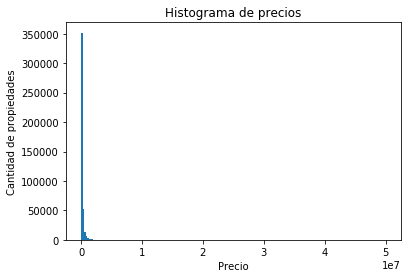

In [92]:
plt.hist(df.loc[df['price_aprox_usd'] > 0]['price_aprox_usd'], bins=200)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios")
plt.show()

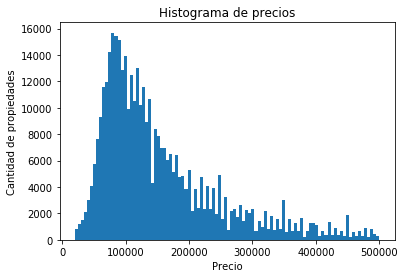

In [93]:
plt.hist(df.loc[(df['price_aprox_usd'] > 0) & (df['price_aprox_usd'] < 500000)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios")
plt.figure(figsize=(17, 1))
plt.show()

## Tipos de propiedades

In [94]:
df['property_type'].value_counts()

apartment    289440
house        105353
PH            26864
store          8783
Name: property_type, dtype: int64

Acá nos damos cuentas los tipos de propiedades existentes. La gran mayoría son departamentos o casas residenciales.

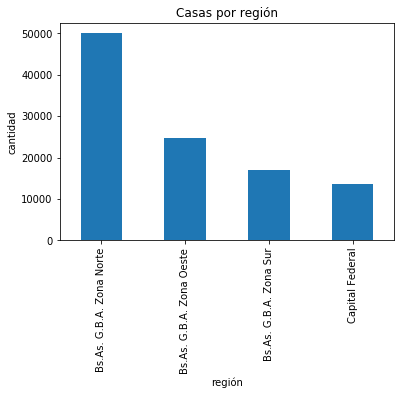

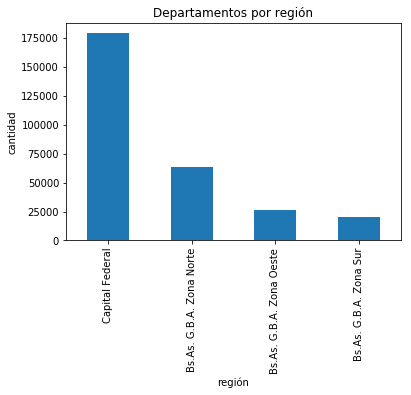

In [95]:
houses_by_state = df.loc[df['property_type'] == 'house']['state'].value_counts().plot(kind='bar')
houses_by_state.set_xlabel(u'región')
houses_by_state.set_ylabel('cantidad')
houses_by_state.set_title(u'Casas por región')
plt.show()
apartments_by_state = df.loc[df['property_type'] == 'apartment']['state'].value_counts().plot(kind='bar')
apartments_by_state.set_xlabel(u'región')
apartments_by_state.set_ylabel('cantidad')
apartments_by_state.set_title(u'Departamentos por región')
plt.show()

Como es de esperar, el grueso de las propiedades de tipo departamento están dentro de CABA, y las casas, afuera.

## Precios según tipo de propiedad

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa44d18f6d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa44ce2dd50>]], dtype=object)

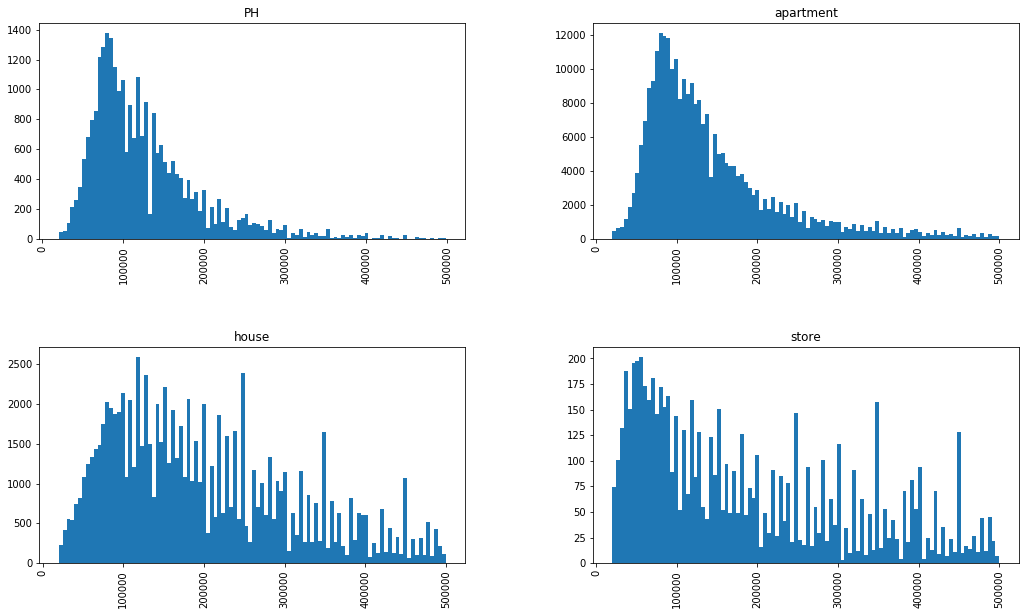

In [96]:
low_prices = df.loc[df['price_aprox_usd'] < 500000]
low_prices['price_aprox_usd'].hist(by=df['property_type'], bins=100, figsize=(17, 10))


Los precios de PH y departamentos se ajusta más a los de los precios en conjunto, mientras que las casas y negocios varían mucho más. Se espera que la media de estas últimas sean mayores a las primeras

In [97]:
df.groupby('property_type')['price_aprox_usd'].mean()

property_type
PH           134283.359548
apartment    179837.202638
house        283642.037526
store        400301.847175
Name: price_aprox_usd, dtype: float64

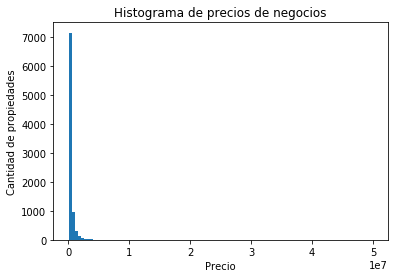

In [98]:
stores = df[df['property_type'] == 'store']
plt.hist(stores.loc[(stores['price_aprox_usd'] > 0)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios de negocios")
plt.figure(figsize=(17, 1))
plt.show()

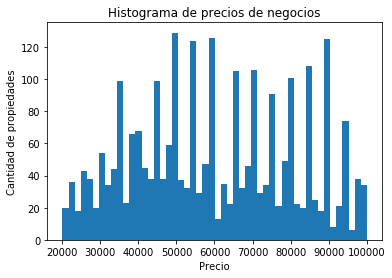

In [99]:
stores = df[df['property_type'] == 'store']
plt.hist(stores.loc[(stores['price_aprox_usd'] > 0) & (stores['price_aprox_usd'] < 100000)]['price_aprox_usd'], bins=50)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios de negocios")
plt.figure(figsize=(17, 1))
plt.show()

In [100]:
df.groupby('property_type')['price_aprox_usd'].std()

property_type
PH           251465.202489
apartment    302440.185443
house        420595.739062
store        930108.529016
Name: price_aprox_usd, dtype: float64

Se puede ver que el desvío (y la varianza) de las propiedades de tipo negocio es mucho más grande que las demás

## Barrios más caros

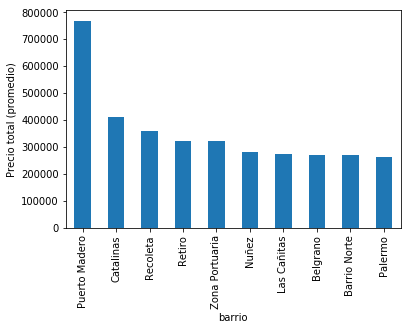

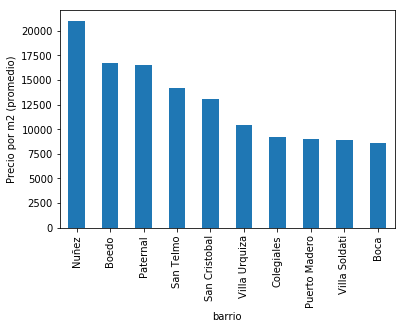

In [101]:
price = df.loc[df['state'] == 'Capital Federal'].loc[df['property_type'] == 'apartment'].groupby('barrio')['price_aprox_usd'].mean().nlargest(10).plot(kind='bar')
price.set_ylabel("Precio total (promedio)")
plt.show()
price_per_m2 = df.loc[df['state'] == 'Capital Federal'].loc[df['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().nlargest(10).plot(kind='bar')
price_per_m2.set_ylabel("Precio por m2 (promedio)")
plt.show()

Se puede observar que algunos barrios coinciden en ambos casos. En particular el primer gráfico es consistente con [fuentes externas](http://www.lanacion.com.ar/2059858-los-barrios-mas-caros-de-la-ciudad-para-alquilar-un-departamento-de-dos-ambientes). Investigo 'Catalinas':

In [102]:
df.loc[df['barrio'] == 'Catalinas']

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
495,Argentina,2015-09-12,USD,NaN,NaN,NaN,-34.603714,"-34.6037137392,-58.3815808896",-58.381581,sell,...,350000.0,3043.478261,store,NaN,115.0,NaN,0.0,Excelente Local situado en plena zona turística.,Capital Federal,Catalinas
71069,Argentina,2016-09-17,USD,NaN,NaN,NaN,-34.603684,"-34.6036844,-58.3815591",-58.381559,sell,...,74500.0,2328.125000,apartment,NaN,32.0,NaN,37.0,Departamento en venta ideal alquiler temporar...,Capital Federal,Catalinas
112625,Argentina,2016-12-04,USD,NaN,NaN,NaN,-34.627206,"-34.6272058442,-58.3614053355",-58.361405,sell,...,85000.0,1517.857143,apartment,3.0,56.0,NaN,56.0,Depto. de 3 ambientes con vista abierta.,Capital Federal,Catalinas
143065,Argentina,2017-02-13,USD,NaN,NaN,NaN,-34.600004,"-34.6000039032,-58.376624255",-58.376624,sell,...,550000.0,1929.824561,apartment,5.0,285.0,NaN,300.0,Excelente departamento antiguo en venta recicl...,Capital Federal,Catalinas
888995,NaN,2013-08-28,USD,NaN,NaN,NaN,-34.594029,"-34.594029,-58.379602",-58.379602,sell,...,650000.0,NaN,apartment,5.0,NaN,252.0,NaN,NaN,Capital Federal,Catalinas
925593,NaN,2013-12-11,USD,NaN,NaN,NaN,-34.594029,"-34.594029,-58.379602",-58.379602,sell,...,590000.0,NaN,apartment,5.0,NaN,252.0,NaN,NaN,Capital Federal,Catalinas
1018329,NaN,2013-12-02,USD,NaN,NaN,NaN,-34.594029,"-34.594029,-58.379602",-58.379602,sell,...,520000.0,NaN,apartment,5.0,NaN,270.0,NaN,NaN,Capital Federal,Catalinas
1292681,NaN,2015-06-26,USD,NaN,NaN,NaN,-34.594712,"-34.5947117175,-58.3741347454",-58.374135,sell,...,390000.0,NaN,store,NaN,NaN,115.0,NaN,Local a la calle en pleno centro porteño: Roja...,Capital Federal,Catalinas
1364770,NaN,2015-09-11,USD,NaN,NaN,NaN,-34.594949,"-34.5949487,-58.373328",-58.373328,sell,...,350000.0,NaN,store,NaN,NaN,115.0,NaN,Catalinas venta local a la calle en Dr.Ricardo...,Capital Federal,Catalinas
1385729,NaN,2015-09-12,USD,NaN,NaN,NaN,-29.537050,"-29.5370502,-62.2660294",-62.266029,sell,...,350000.0,NaN,store,NaN,NaN,0.0,NaN,Excelente Local situado en plena zona turística.,Capital Federal,Catalinas


,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
233,Argentina,2015-08-04,USD,9500.0,17.0,NaN,-34.564732,"-34.5647325,-58.4412528",-58.441253,sell,...,810000.00,2629.870130,apartment,5.0,308.0,NaN,417.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
453,Argentina,2015-09-07,USD,2000.0,6.0,NaN,-34.567984,"-34.567984,-58.4337562",-58.433756,sell,...,178600.00,5102.857143,apartment,2.0,35.0,NaN,44.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
585,Argentina,2015-09-24,USD,9800.0,17.0,NaN,-34.564741,"-34.5647408,-58.4412972981",-58.441297,sell,...,810000.00,2629.870130,apartment,5.0,308.0,NaN,417.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
1530,Argentina,2016-01-12,USD,3000.0,9.0,NaN,-34.567984,"-34.5679842,-58.4337564",-58.433756,sell,...,378900.00,4985.526316,apartment,3.0,76.0,NaN,92.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
1531,Argentina,2016-01-12,USD,2000.0,9.0,NaN,-34.567984,"-34.5679842,-58.4337564",-58.433756,sell,...,277100.00,4329.687500,apartment,2.0,64.0,NaN,73.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
1812,Argentina,2016-01-30,USD,NaN,5.0,NaN,NaN,NaN,NaN,sell,...,112000.00,2434.782609,apartment,3.0,46.0,NaN,46.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
1815,Argentina,2015-09-24,USD,NaN,NaN,NaN,-34.566397,"-34.5663966,-58.431964",-58.431964,sell,...,260000.00,2222.222222,apartment,3.0,117.0,NaN,117.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas
2749,Argentina,2016-01-14,USD,NaN,NaN,NaN,-34.566025,"-34.56602478,-58.43721008",-58.437210,sell,...,270000.00,NaN,apartment,NaN,NaN,NaN,NaN,U$D 270.000 - Departamento en Venta - Soldado ...,Capital Federal,Las Cañitas
3252,Argentina,2015-08-10,USD,2.0,NaN,NaN,-38.416097,"-38.416097,-63.616672",-63.616672,sell,...,180000.00,2368.421053,apartment,3.0,76.0,NaN,76.0,Departamentos venta,Capital Federal,Las Cañitas
3311,Argentina,2016-01-15,USD,2000.0,NaN,NaN,-34.570373,"-34.5703729,-58.434203",-58.434203,sell,...,295000.00,3105.263158,apartment,NaN,95.0,NaN,105.0,DEPARTAMENTO EN VENTA,Capital Federal,Las Cañitas


In [115]:
df.loc[df['barrio'] == 'Zona Portuaria']

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
183088,Argentina,2017-04-01,USD,NaN,NaN,NaN,-34.578833,"-34.5788332,-58.3731163",-58.373116,sell,...,320000.0,4266.666667,apartment,3.0,75.0,NaN,145.0,PUERTO MADERO,Capital Federal,Zona Portuaria


In [1]:
df_sin_outlier = df[df['barrio'] != 'Catalinas']
df_sin_outlier = df_sin_outlier[df_sin_outlier['barrio'] != 'Zona Portuaria']
price = df_sin_outlier.loc[df_sin_outlier['state'] == 'Capital Federal'].loc[df_sin_outlier['property_type'] == 'apartment'].groupby('barrio')['price_aprox_usd'].mean().nlargest(10).plot(kind='bar', figsize=(17, 10))
price.set_ylabel("Precio total (promedio)")
plt.show()

NameError: name 'df' is not defined

In [104]:
df_deptos_caros_capital = df.dropna(subset=['lat', 'lon'], how='any').loc[(df.property_type.str.contains('apartment'))&(df.place_name == 'Capital Federal')].sort_values('price_per_m2',ascending=False).head(100)

### Correlación tamaño - precio de las propiedades

In [105]:
df.surface_total_in_m2.isnull().value_counts()

True     321333
False    109107
Name: surface_total_in_m2, dtype: int64

In [106]:
df.surface_in_m2.isnull().value_counts()

True     234879
False    195561
Name: surface_in_m2, dtype: int64

In [107]:
def surface(x):
    if x.surface_total_in_m2:
        return x.surface_total_in_m2
    
    if x.surface_in_m2:
        return x.surface_in_m2
    
    if x.surface_covered_in_m2:
        return x.surface_covered_in_m2
    
    return 0

sf = df.apply(surface, axis=1)
sf.isnull().value_counts()

True     328436
False    102004
dtype: int64

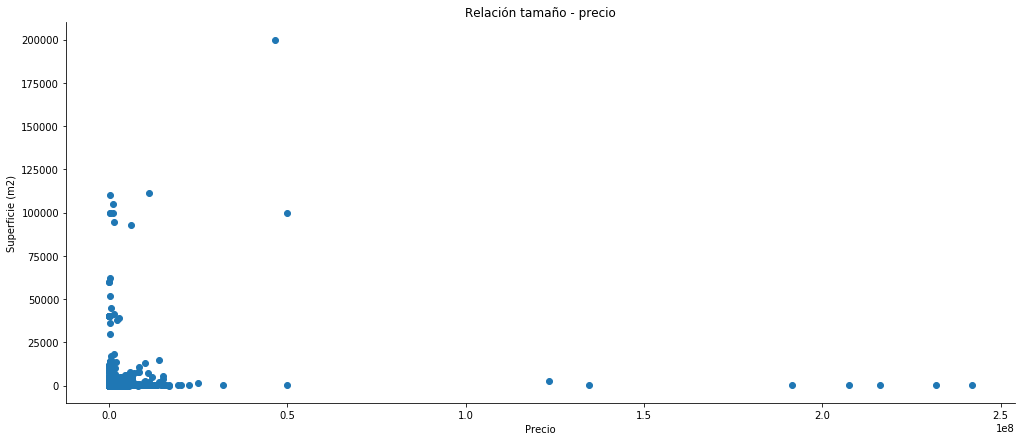

In [108]:
x = df.price
y = df.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)

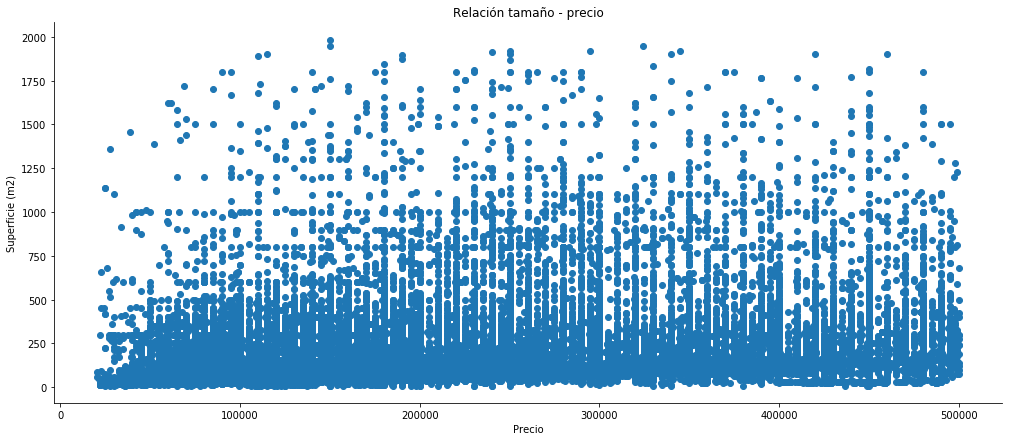

In [109]:
filtro = df.loc[(df.price < 500000) & (df.price > 20000)]
filtro = filtro.loc[(filtro.surface_total_in_m2 < 2000) & (filtro.surface_total_in_m2 > 0)]

x = filtro.price
y = filtro.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)

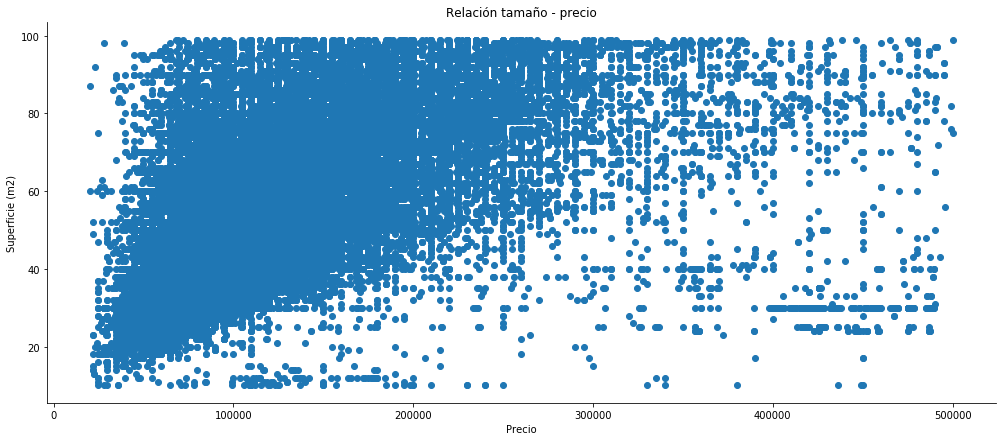

In [110]:
filtro = df.loc[(df.price < 500000) & (df.price > 20000)]
filtro = filtro.loc[(filtro.surface_total_in_m2 < 100) & (filtro.surface_total_in_m2 > 0)]

x = filtro.price
y = filtro.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)


En el orden de superficies bajas se puede notar una relación entre el precio y el tamaño d

In [111]:
df

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
0,Argentina,2015-07-01,USD,1500.0,NaN,3430234.0,-34.574594,"-34.5745944268,-58.4192548517",-58.419255,sell,...,71000.00,2448.275862,apartment,1.0,29.0,NaN,29.0,Departamento en Palermo,Capital Federal,Palermo
1,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,96000.00,2285.714286,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 6º- A ESTRENAR,Capital Federal,Villa del Parque
2,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,86000.00,2047.619048,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 4º- A ESTRENAR,Capital Federal,Villa del Parque
3,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.639086,"-34.639086,-58.369347",-58.369347,sell,...,165000.00,2115.384615,apartment,1.0,78.0,NaN,86.0,DEPARTAMENTO EN VENTA,Capital Federal,Barracas
4,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.678121,"-34.6781214564,-58.3922113975",-58.392211,sell,...,85000.00,1133.333333,house,NaN,75.0,NaN,65.0,Duplex en PH - Avellaneda - Excelente,Capital Federal,Barracas
5,Argentina,2015-07-02,USD,NaN,NaN,3435259.0,-34.611630,"-34.611630054,-58.4013462067",-58.401346,sell,...,56900.00,1625.714286,apartment,NaN,35.0,NaN,35.0,"Departamento en Venta en Congreso, Capital Fed...",Capital Federal,Congreso
10,Argentina,2015-07-02,USD,5000.0,NaN,3436077.0,-34.569881,"-34.5698809,-58.4417543",-58.441754,sell,...,420000.00,3043.478261,apartment,NaN,138.0,NaN,153.0,departamento de 3 ambientes con dependencia de...,Capital Federal,Belgrano
11,Argentina,2015-07-02,USD,NaN,NaN,3433955.0,NaN,NaN,NaN,sell,...,550000.00,916.666667,house,NaN,600.0,NaN,920.0,"Casa 920m² con 3 Plantas en Abriata, Pablo A. ...",Capital Federal,
12,Argentina,2015-07-02,USD,NaN,NaN,3433955.0,NaN,NaN,NaN,sell,...,1700000.00,3400.000000,house,NaN,500.0,NaN,2129.0,"Casa 2129m² con Dependencias en Rodo, J. E. 13...",Capital Federal,
13,Argentina,2015-07-02,USD,NaN,NaN,3433955.0,NaN,NaN,NaN,sell,...,750000.00,1250.000000,house,NaN,600.0,NaN,1838.0,"Casa 1838m² con Teléfono en Abriata, Pablo A. ...",Capital Federal,


In [112]:
geometry = [Point(x,y) for x,y in zip(df_deptos_caros_capital['lon'], df_deptos_caros_capital['lat'])]

gs = GeoDataFrame(df_deptos_caros_capital, geometry=geometry)

In [113]:
gs.plot(marker='o', color='red', markersize=60, figsize=(4, 4))
mplleaflet.display()

In [114]:
df.loc[df['place_name'] == 'Capital Federal'].groupby('place_name')['price'].mean()

place_name
Capital Federal    419761.632313
Name: price, dtype: float64